In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from utils import mnist, plot_graphs, plot_mnist, to_onehot
import numpy as np
import os 

%matplotlib inline

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [3]:
root_folder = 'FC_AAE_C_results'
fixed_folder = root_folder + '/Fixed_results/'
recon_folder = root_folder + '/Recon_results/'

if os.path.isdir(root_folder):
    !rm -r $root_folder
os.mkdir(root_folder)
os.mkdir(fixed_folder)
os.mkdir(recon_folder)

In [4]:
mnist_tanh = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.5,), (0.5,)),
                lambda x: x.to(device)
           ])

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

lr = 0.0001
prior_size = 10
train_epoch = 1000
batch_size = 250
train_loader, valid_loader, test_loader = mnist(batch_size=batch_size, valid=10000, transform=mnist_tanh)
fixed_z = torch.randn((10, prior_size)).repeat((1,10)).view(-1, prior_size).to(device)
fixed_z_label = to_onehot(torch.tensor(list(range(10))).repeat((10)), 10).to(device)
fixed_data, fixed_label = next(iter(test_loader))
fixed_data = fixed_data[:100].to(device)
fixed_label = to_onehot(fixed_label[:100], 10).to(device)

cuda:0


In [6]:
data, label = next(iter(train_loader))

In [7]:
class FullyConnected(nn.Module):
    def __init__(self, sizes, dropout=False, activation_fn=nn.Tanh(), flatten=False, 
                 last_fn=None, first_fn=None, device='cpu'):
        super(FullyConnected, self).__init__()
        layers = []
        self.flatten = flatten
        if first_fn is not None:
            layers.append(first_fn)
        for i in range(len(sizes) - 2):
            layers.append(nn.Linear(sizes[i], sizes[i+1]))
            if dropout:
                layers.append(nn.Dropout(dropout))
            layers.append(activation_fn) # нам не нужен дропаут и фнкция активации в последнем слое
        else: 
            layers.append(nn.Linear(sizes[-2], sizes[-1]))
        if last_fn is not None:
            layers.append(last_fn)
        self.model = nn.Sequential(*layers)
        self.to(device)
        
    def forward(self, x, y=None):
        if self.flatten:
            x = x.view(x.shape[0], -1)
        if y is not None:
            x = torch.cat([x, y], dim=1)
        return self.model(x)

In [8]:
Enc = FullyConnected([28*28, 1024, 1024, prior_size], activation_fn=nn.LeakyReLU(0.2), flatten=True, device=device)
Dec = FullyConnected([prior_size+10, 1024, 1024, 28*28], activation_fn=nn.LeakyReLU(0.2), last_fn=nn.Tanh(), device=device)
Disc = FullyConnected([prior_size, 1024, 1024, 1], dropout=0.3, activation_fn=nn.LeakyReLU(0.2), device=device)

Enc_optimizer = optim.Adam(Enc.parameters(), lr=lr)
Dec_optimizer = optim.Adam(Dec.parameters(), lr=lr)
Disc_optimizer = optim.Adam(Disc.parameters(), lr=lr)

In [9]:
train_log = {'E': [],'AE': [], 'D': []}
test_log = {'E': [],'AE': [], 'D': []}

In [10]:
batch_zeros = torch.zeros((batch_size, 1)).to(device)
batch_ones = torch.ones((batch_size, 1)).to(device)

In [11]:
def train(epoch, Enc, Dec, Disc, log=None):
    train_size = len(train_loader.sampler)
    for batch_idx, (data, label) in enumerate(train_loader):
        label = to_onehot(label, 10, device)
        # train D
        Enc.zero_grad()
        Disc.zero_grad()
        
        z = torch.randn((batch_size, prior_size)).to(device)
        z_label = to_onehot(np.random.randint(0, 10, (batch_size)), 10, device)

        fake_pred = Disc(Enc(data))
        true_pred = Disc(z)

        
        fake_loss = F.binary_cross_entropy_with_logits(fake_pred, batch_zeros)
        true_loss = F.binary_cross_entropy_with_logits(true_pred, batch_ones)
        
        Disc_loss = 0.5*(fake_loss + true_loss)
        
        Disc_loss.backward()
        Disc_optimizer.step()
        
        # train AE
        Enc.zero_grad()
        Dec.zero_grad()
        Disc.zero_grad()
        
        z = torch.randn((batch_size, prior_size))
        z_label = to_onehot(np.random.randint(0, 10, (batch_size)), 10)
        
        latent = Enc(data)
        reconstructed = Dec(latent, label).view(-1, 1, 28, 28)
        fake_pred = Disc(latent)
        
        Enc_loss = F.binary_cross_entropy_with_logits(fake_pred, batch_ones)
        AE_loss = F.mse_loss(reconstructed, data)
        G_loss = AE_loss + Enc_loss
        
        G_loss.backward()
        Dec_optimizer.step()
        Enc_optimizer.step()
            
        if batch_idx % 100 == 0:
            line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
                epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
            losses = 'E: {:.4f}, AE: {:.4f}, D: {:.4f}'.format(Enc_loss.item(), AE_loss.item(), Disc_loss.item())
            print(line + losses)
            
    else:
        batch_idx += 1
        line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
            epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
        losses = 'E: {:.4f}, AE: {:.4f}, D: {:.4f}'.format(Enc_loss.item(), AE_loss.item(), Disc_loss.item())
        print(line + losses)
        log['E'].append(Enc_loss.item())
        log['AE'].append(AE_loss.item())
        log['D'].append(Disc_loss.item())

In [12]:
def test(Enc, Dec, Disc, loader, epoch, log=None):
    test_size = len(loader)
    E_loss = 0.
    AE_loss = 0.
    D_loss = 0.
    test_loss = {'E': 0., 'AE': 0., 'D': 0.}
    with torch.no_grad():
        for data, label in loader:
            label = to_onehot(label, 10, device)
            z = torch.randn((batch_size, prior_size)).to(device)
            z_label = to_onehot(np.random.randint(0, 10, (batch_size)), 10, device)
            latent = Enc(data)
            reconstructed = Dec(latent, label).view(-1, 1, 28, 28)
            fake_pred = Disc(latent)
            true_pred = Disc(z)
        
            fake_loss = F.binary_cross_entropy_with_logits(fake_pred, batch_zeros).item()
            true_loss = F.binary_cross_entropy_with_logits(true_pred, batch_ones).item()
            
            D_loss += 0.5*(fake_loss + true_loss)
            E_loss += F.binary_cross_entropy_with_logits(fake_pred, batch_ones).item()
            AE_loss += F.mse_loss(reconstructed, data)
            
        E_loss /= test_size
        D_loss /= test_size
        AE_loss /= test_size

        fixed_gen = Dec(fixed_z, fixed_z_label).cpu().data.numpy().reshape(100, 1, 28, 28)
        plot_mnist(fixed_gen, (10, 10), True, fixed_folder + '%03d.png' % epoch)
        fixed_reconstruction = Dec(Enc(fixed_data), fixed_label).cpu().data.numpy().reshape(100, 1, 28, 28)
        plot_mnist(fixed_reconstruction, (10, 10), True, recon_folder + '%03d.png' % epoch)
        
    report = 'Test losses. E: {:.4f}, AE: {:.4f}, D: {:.4f}'.format(E_loss, AE_loss, D_loss)
    print(report)

Train Epoch: 1 [0/50000 (0%)]	Losses E: 0.7006, AE: 0.9246, D: 0.7100
Train Epoch: 1 [25000/50000 (50%)]	Losses E: 1.3876, AE: 0.2699, D: 5.2129
Train Epoch: 1 [50000/50000 (100%)]	Losses E: 0.7957, AE: 0.3339, D: 1.6309


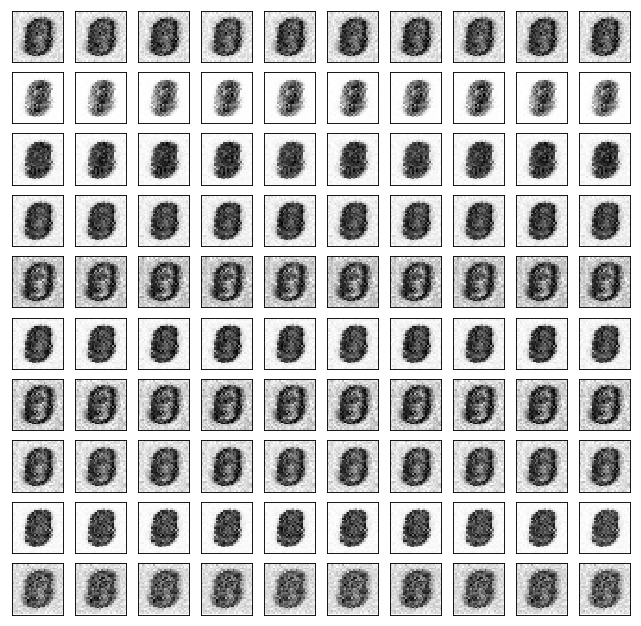

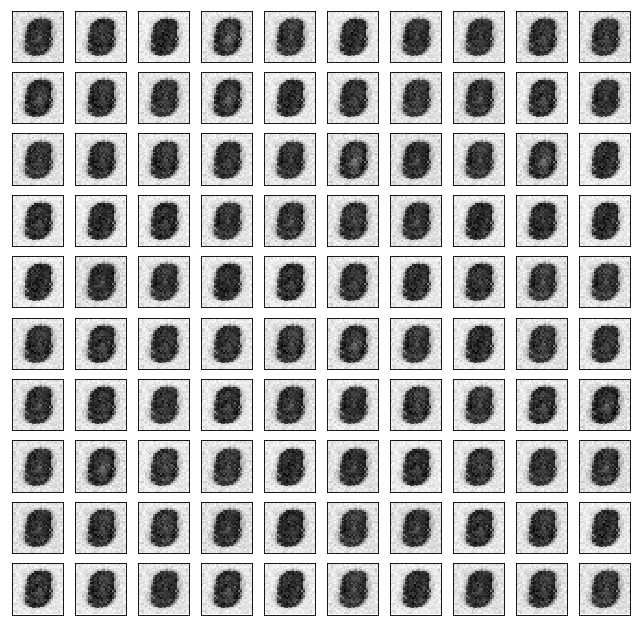

Test losses. E: 0.7982, AE: 0.3459, D: 1.5493
Train Epoch: 2 [0/50000 (0%)]	Losses E: 0.8060, AE: 0.3458, D: 1.5554
Train Epoch: 2 [25000/50000 (50%)]	Losses E: 0.5721, AE: 0.2579, D: 0.9408
Train Epoch: 2 [50000/50000 (100%)]	Losses E: 1.5814, AE: 0.2578, D: 0.9119


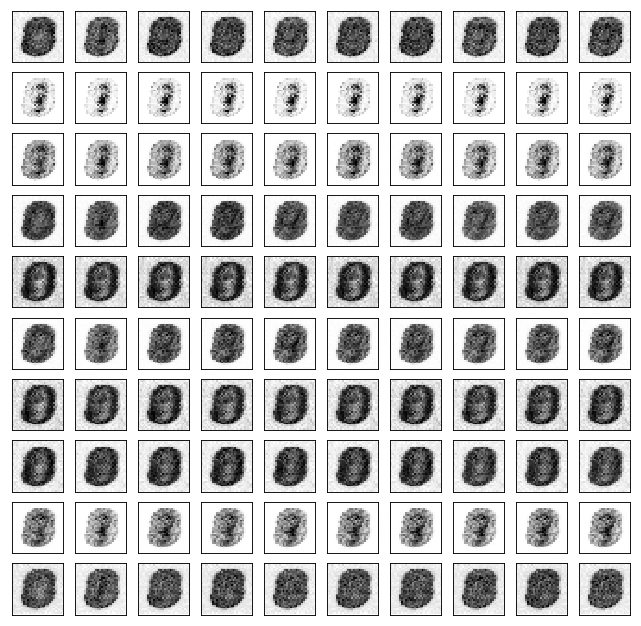

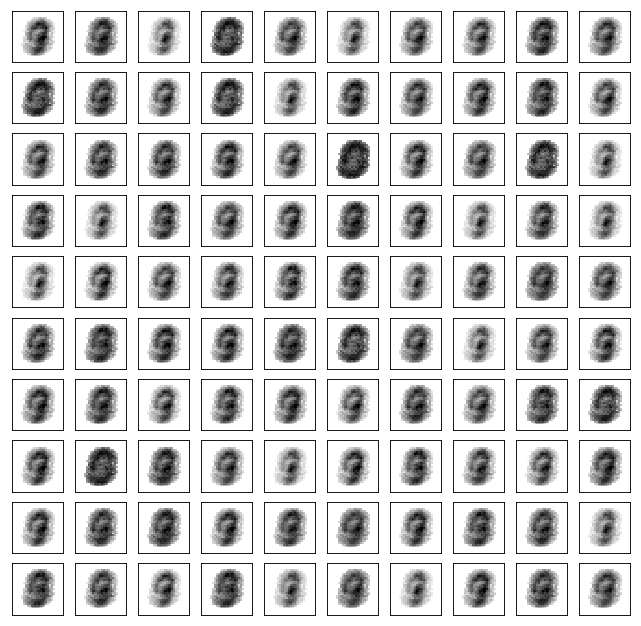

Test losses. E: 0.9872, AE: 0.2531, D: 0.9488
Train Epoch: 3 [0/50000 (0%)]	Losses E: 1.6053, AE: 0.2539, D: 0.9321
Train Epoch: 3 [25000/50000 (50%)]	Losses E: 0.5656, AE: 0.2474, D: 0.9239
Train Epoch: 3 [50000/50000 (100%)]	Losses E: 0.5206, AE: 0.2384, D: 0.7785


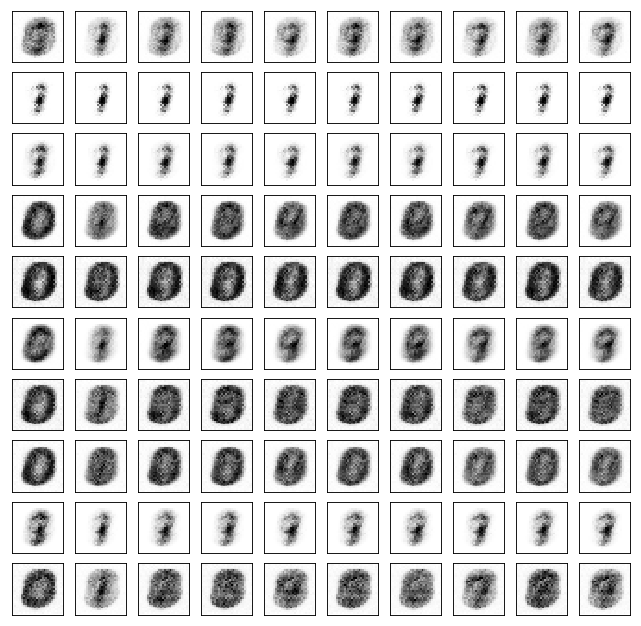

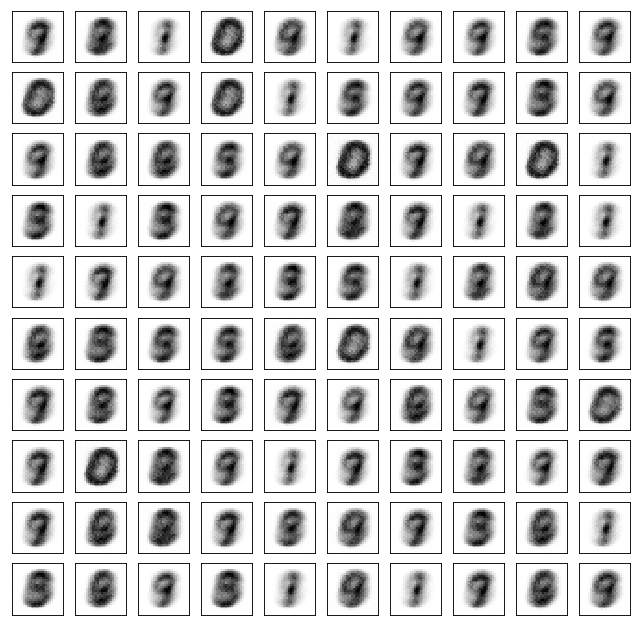

Test losses. E: 0.4978, AE: 0.2368, D: 0.7716
Train Epoch: 4 [0/50000 (0%)]	Losses E: 0.5300, AE: 0.2333, D: 0.7898
Train Epoch: 4 [25000/50000 (50%)]	Losses E: 0.8279, AE: 0.2261, D: 0.7446
Train Epoch: 4 [50000/50000 (100%)]	Losses E: 0.5995, AE: 0.2211, D: 0.8113


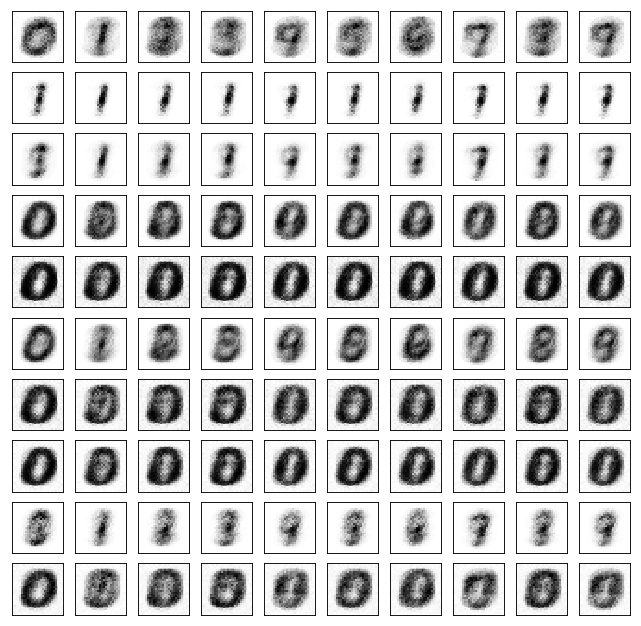

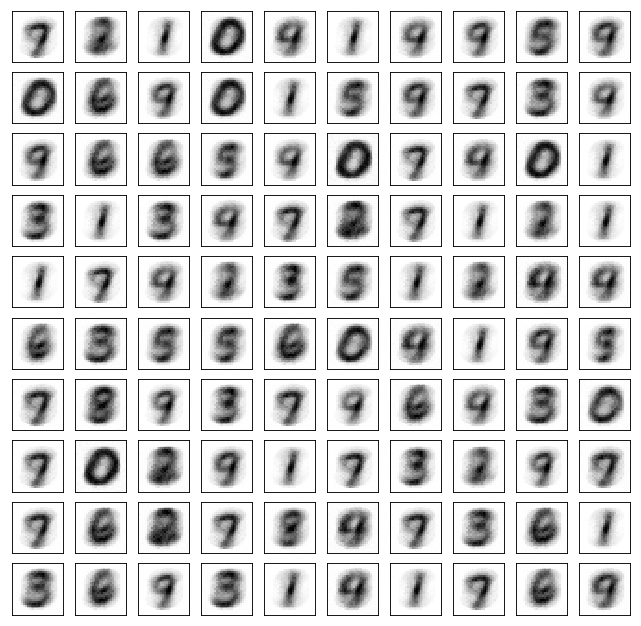

Test losses. E: 0.5881, AE: 0.2192, D: 0.8007
Train Epoch: 5 [0/50000 (0%)]	Losses E: 0.5999, AE: 0.2230, D: 0.8063
Train Epoch: 5 [25000/50000 (50%)]	Losses E: 0.5766, AE: 0.2124, D: 0.7435
Train Epoch: 5 [50000/50000 (100%)]	Losses E: 0.6422, AE: 0.2118, D: 0.7325


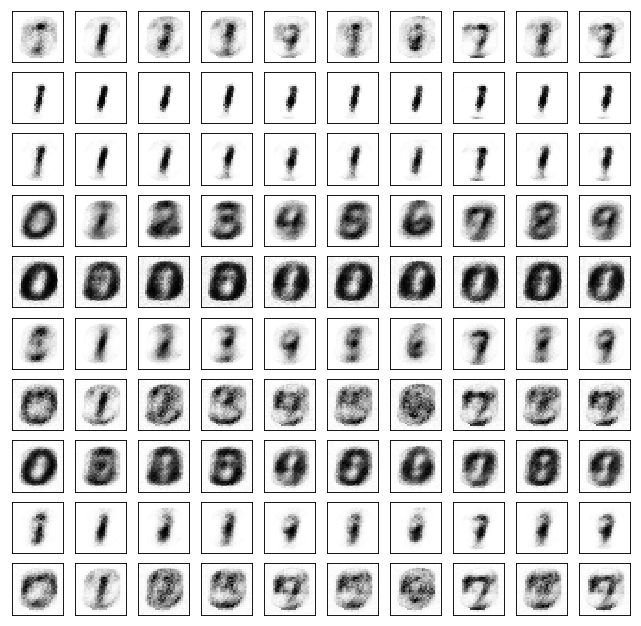

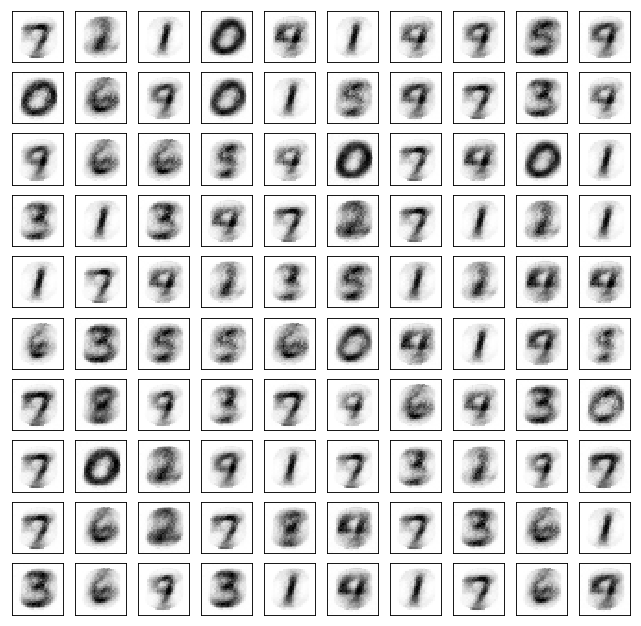

Test losses. E: 0.6097, AE: 0.2120, D: 0.7409
Train Epoch: 6 [0/50000 (0%)]	Losses E: 0.6283, AE: 0.2163, D: 0.7364
Train Epoch: 6 [25000/50000 (50%)]	Losses E: 0.7409, AE: 0.2141, D: 0.7187
Train Epoch: 6 [50000/50000 (100%)]	Losses E: 0.5976, AE: 0.1996, D: 0.7025


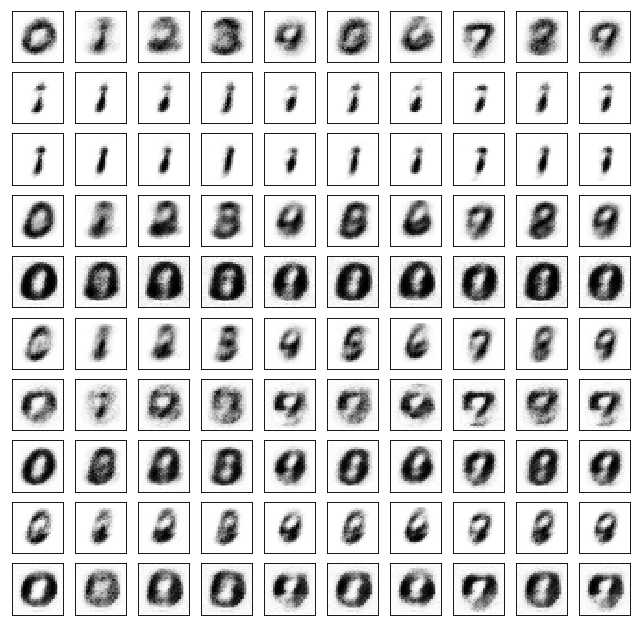

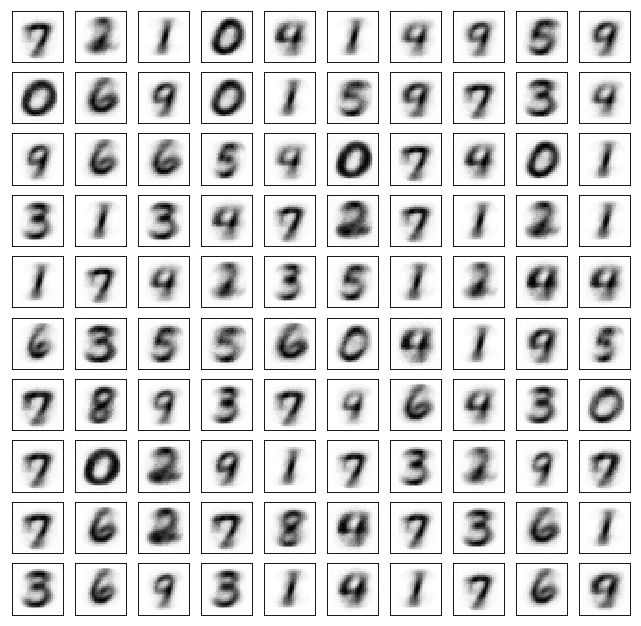

Test losses. E: 0.5934, AE: 0.1993, D: 0.7001
Train Epoch: 7 [0/50000 (0%)]	Losses E: 0.5987, AE: 0.1965, D: 0.7034
Train Epoch: 7 [25000/50000 (50%)]	Losses E: 0.4342, AE: 0.1961, D: 0.8485
Train Epoch: 7 [50000/50000 (100%)]	Losses E: 0.7614, AE: 0.1877, D: 0.7465


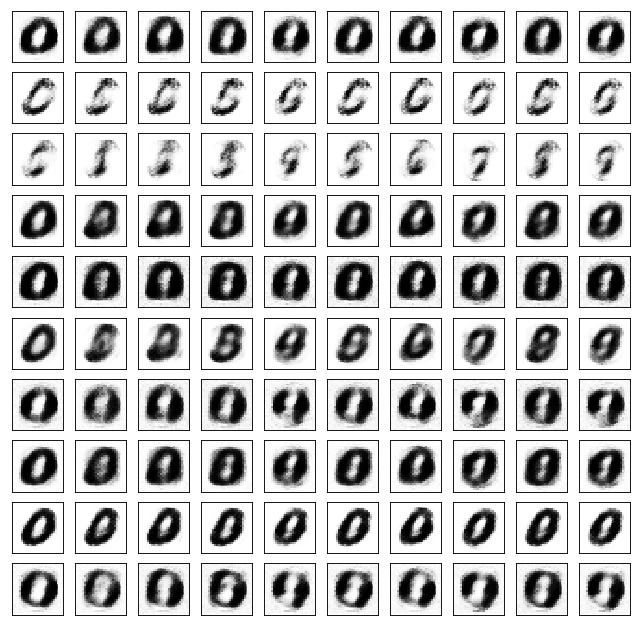

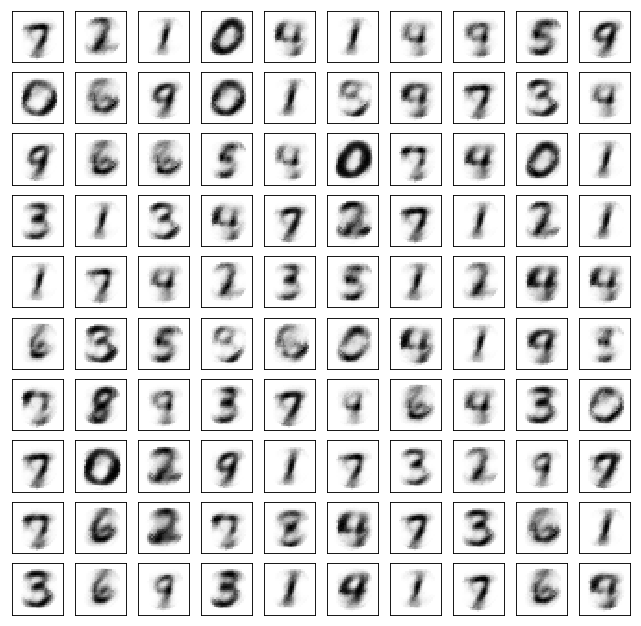

Test losses. E: 0.7236, AE: 0.1898, D: 0.7349
Train Epoch: 8 [0/50000 (0%)]	Losses E: 0.7598, AE: 0.1890, D: 0.7517
Train Epoch: 8 [25000/50000 (50%)]	Losses E: 0.6663, AE: 0.1896, D: 0.7140
Train Epoch: 8 [50000/50000 (100%)]	Losses E: 0.7657, AE: 0.2258, D: 0.6532


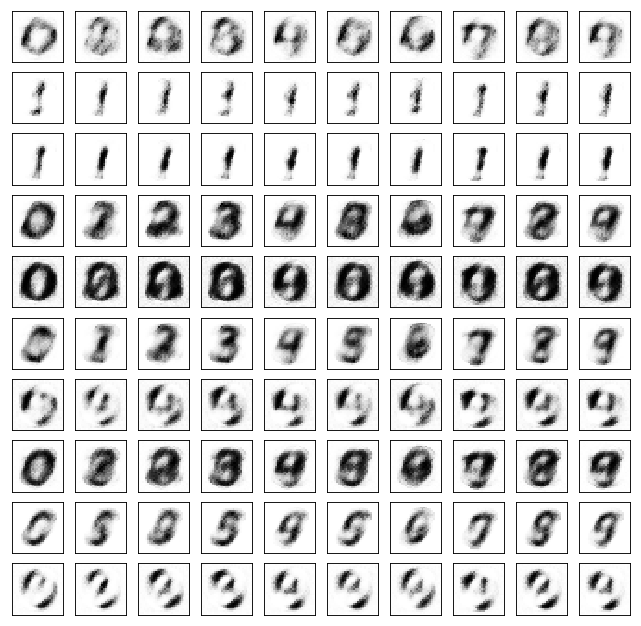

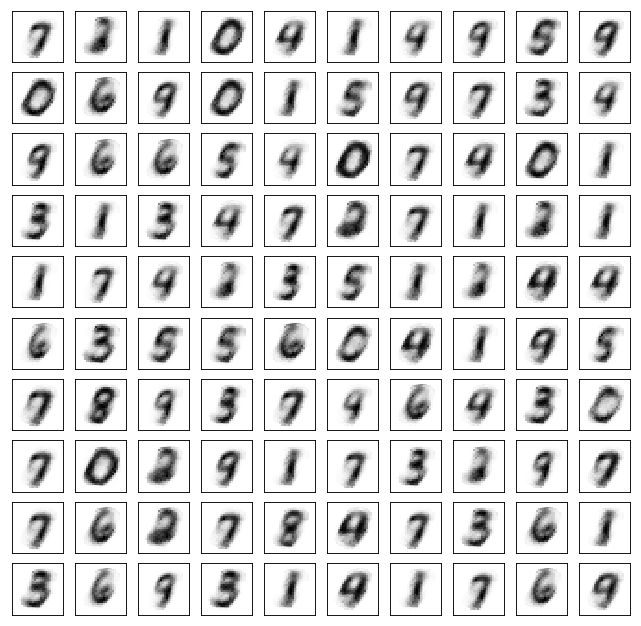

Test losses. E: 0.7374, AE: 0.2143, D: 0.6475
Train Epoch: 9 [0/50000 (0%)]	Losses E: 0.7643, AE: 0.2050, D: 0.6462
Train Epoch: 9 [25000/50000 (50%)]	Losses E: 0.7549, AE: 0.2021, D: 0.7570
Train Epoch: 9 [50000/50000 (100%)]	Losses E: 0.6556, AE: 0.1836, D: 0.7015


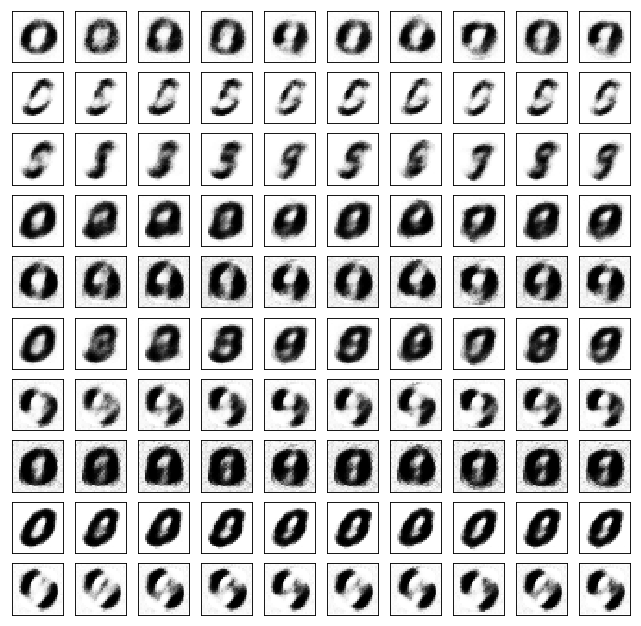

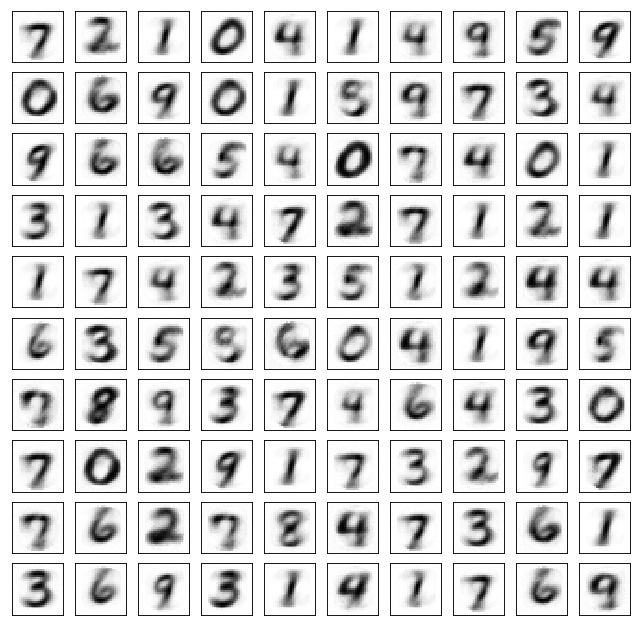

Test losses. E: 0.6527, AE: 0.1780, D: 0.7027
Train Epoch: 10 [0/50000 (0%)]	Losses E: 0.6533, AE: 0.1734, D: 0.7060
Train Epoch: 10 [25000/50000 (50%)]	Losses E: 0.6246, AE: 0.1795, D: 0.7879
Train Epoch: 10 [50000/50000 (100%)]	Losses E: 0.6778, AE: 0.1759, D: 0.7517


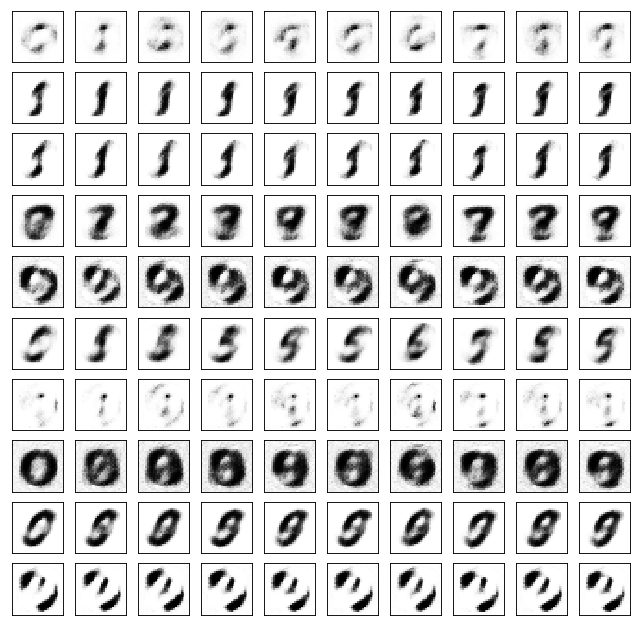

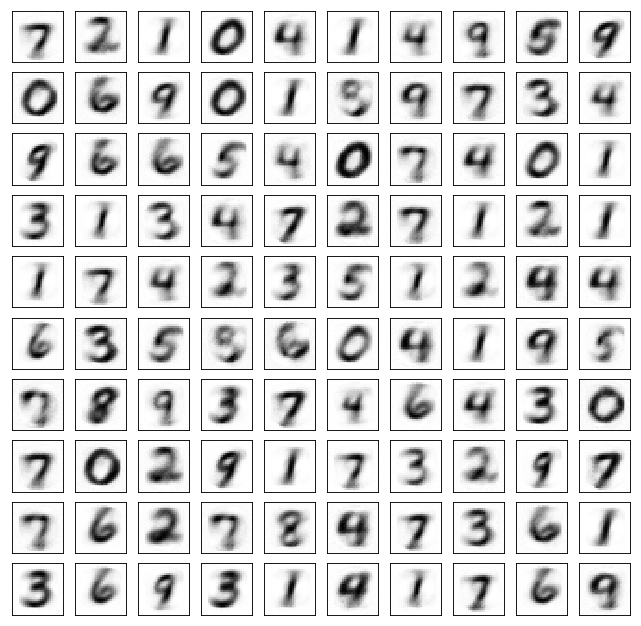

Test losses. E: 0.6746, AE: 0.1735, D: 0.7489
Train Epoch: 11 [0/50000 (0%)]	Losses E: 0.6768, AE: 0.1781, D: 0.7557
Train Epoch: 11 [25000/50000 (50%)]	Losses E: 0.5613, AE: 0.1758, D: 0.7076
Train Epoch: 11 [50000/50000 (100%)]	Losses E: 0.9062, AE: 0.1775, D: 0.7170


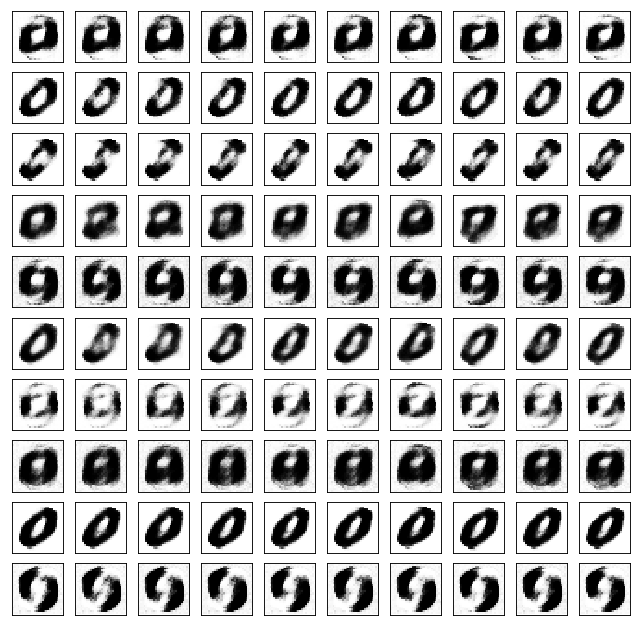

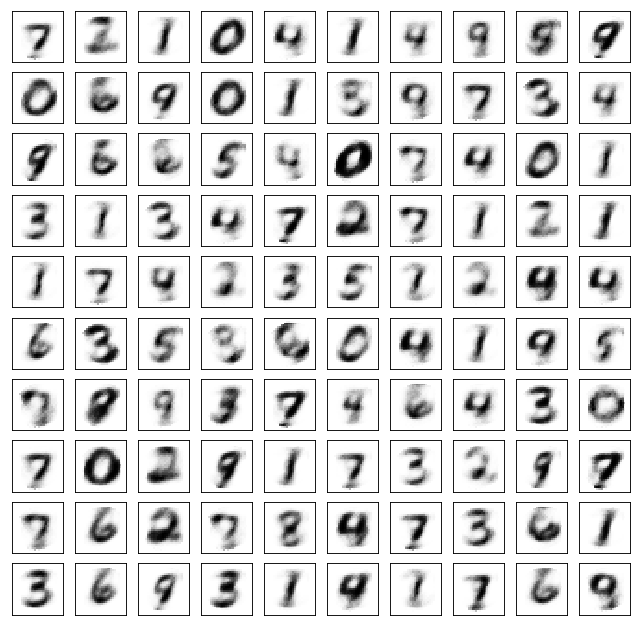

Test losses. E: 0.8001, AE: 0.1735, D: 0.7222
Train Epoch: 12 [0/50000 (0%)]	Losses E: 0.9252, AE: 0.1716, D: 0.7194
Train Epoch: 12 [25000/50000 (50%)]	Losses E: 0.6436, AE: 0.1616, D: 0.7182
Train Epoch: 12 [50000/50000 (100%)]	Losses E: 0.5960, AE: 0.1673, D: 0.7301


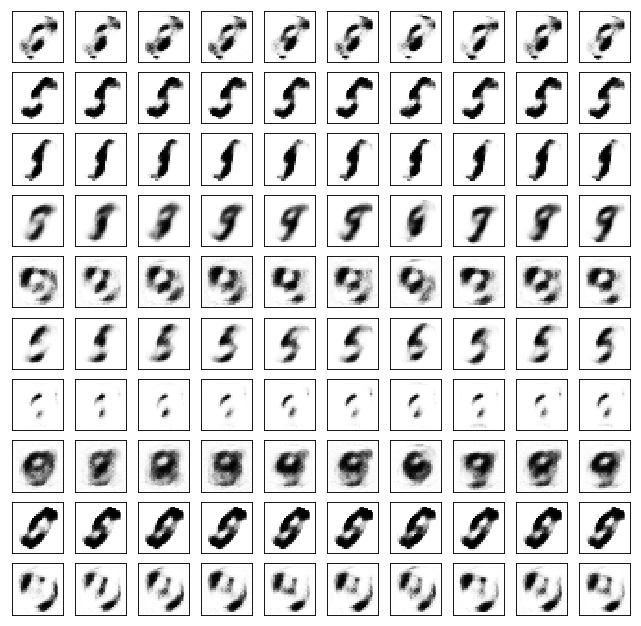

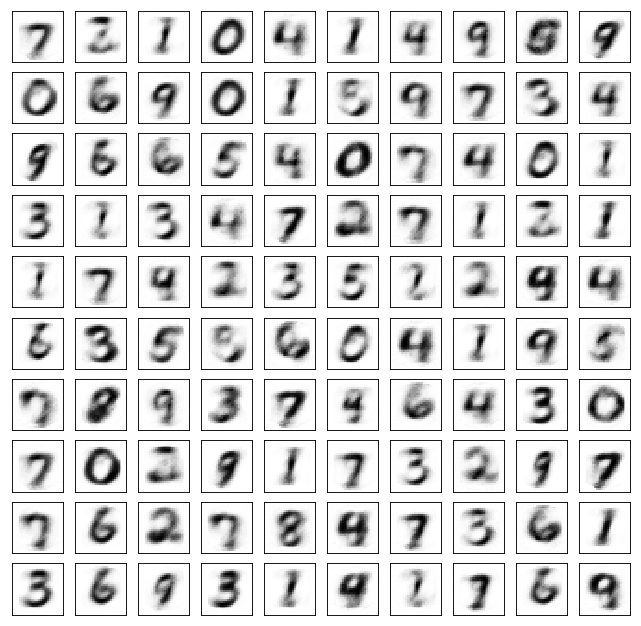

Test losses. E: 0.5856, AE: 0.1614, D: 0.7292
Train Epoch: 13 [0/50000 (0%)]	Losses E: 0.5883, AE: 0.1573, D: 0.7323
Train Epoch: 13 [25000/50000 (50%)]	Losses E: 0.7060, AE: 0.1698, D: 0.7718
Train Epoch: 13 [50000/50000 (100%)]	Losses E: 0.6281, AE: 0.1551, D: 0.7118


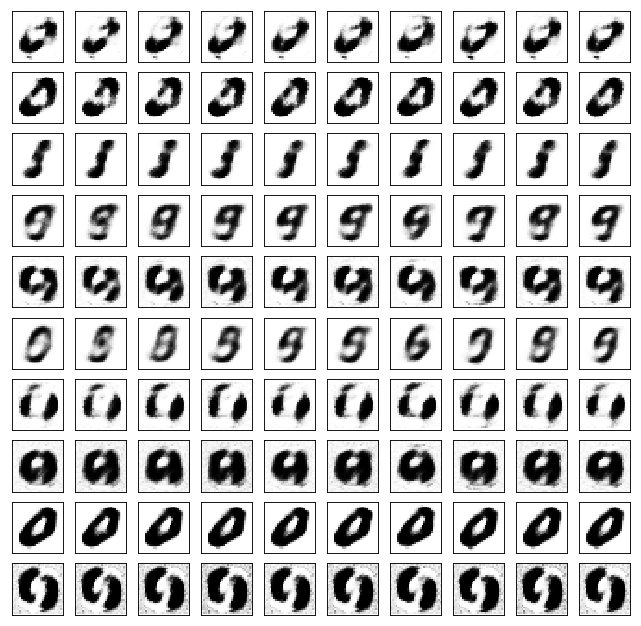

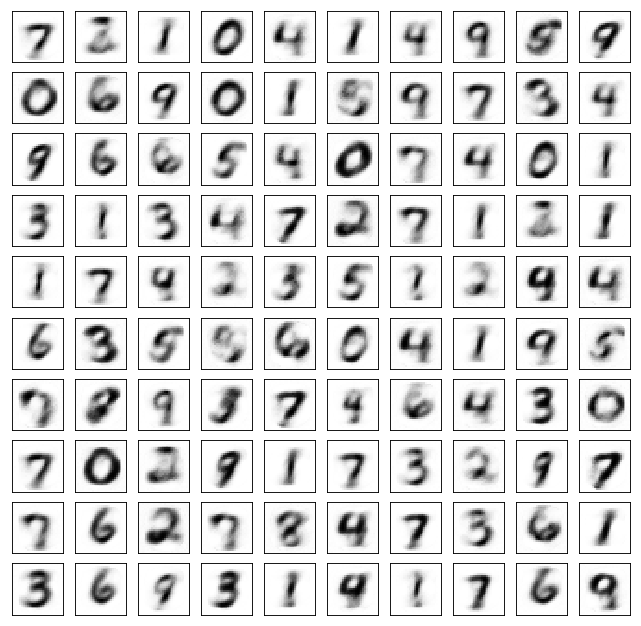

Test losses. E: 0.6267, AE: 0.1562, D: 0.7117
Train Epoch: 14 [0/50000 (0%)]	Losses E: 0.6259, AE: 0.1613, D: 0.7131
Train Epoch: 14 [25000/50000 (50%)]	Losses E: 0.6316, AE: 0.1537, D: 0.6846
Train Epoch: 14 [50000/50000 (100%)]	Losses E: 0.6659, AE: 0.2051, D: 0.7776


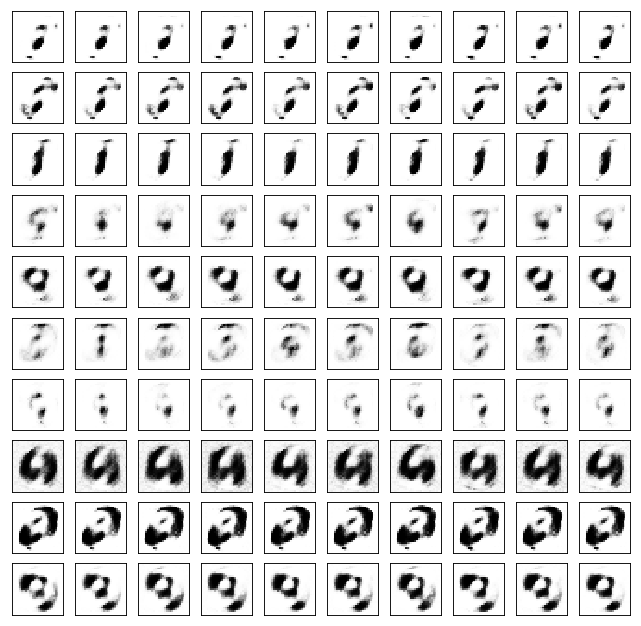

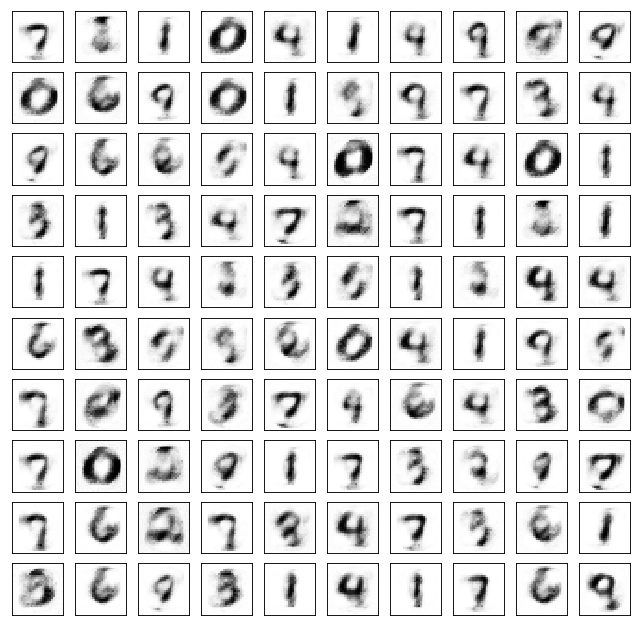

Test losses. E: 0.6644, AE: 0.2008, D: 0.7706
Train Epoch: 15 [0/50000 (0%)]	Losses E: 0.6660, AE: 0.2030, D: 0.7715
Train Epoch: 15 [25000/50000 (50%)]	Losses E: 0.6373, AE: 0.1476, D: 0.7264
Train Epoch: 15 [50000/50000 (100%)]	Losses E: 0.5546, AE: 0.1516, D: 0.7251


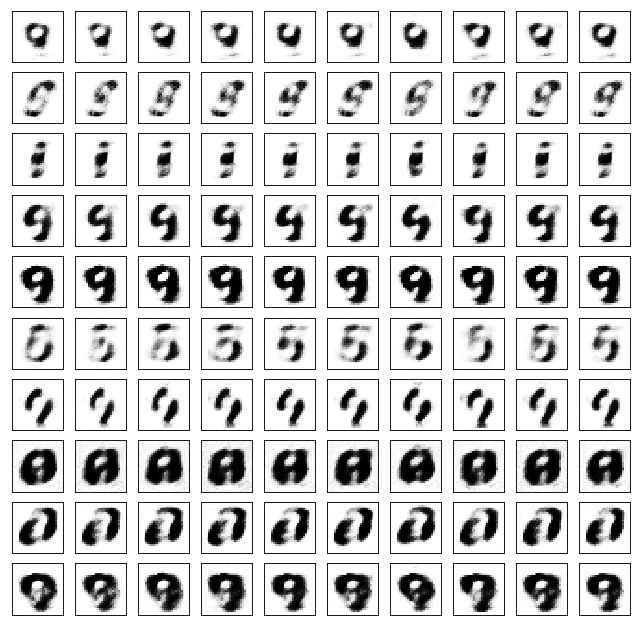

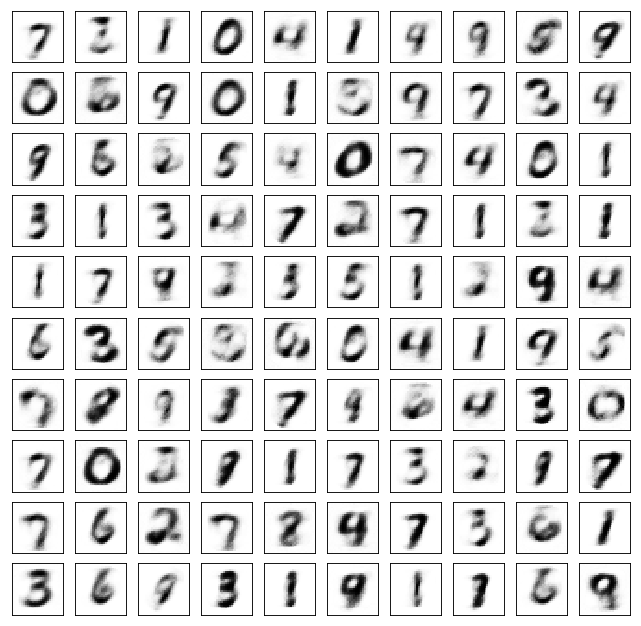

Test losses. E: 0.5442, AE: 0.1544, D: 0.7293
Train Epoch: 16 [0/50000 (0%)]	Losses E: 0.5434, AE: 0.1513, D: 0.7332
Train Epoch: 16 [25000/50000 (50%)]	Losses E: 0.7160, AE: 0.1512, D: 0.7659
Train Epoch: 16 [50000/50000 (100%)]	Losses E: 0.6511, AE: 0.1460, D: 0.6827


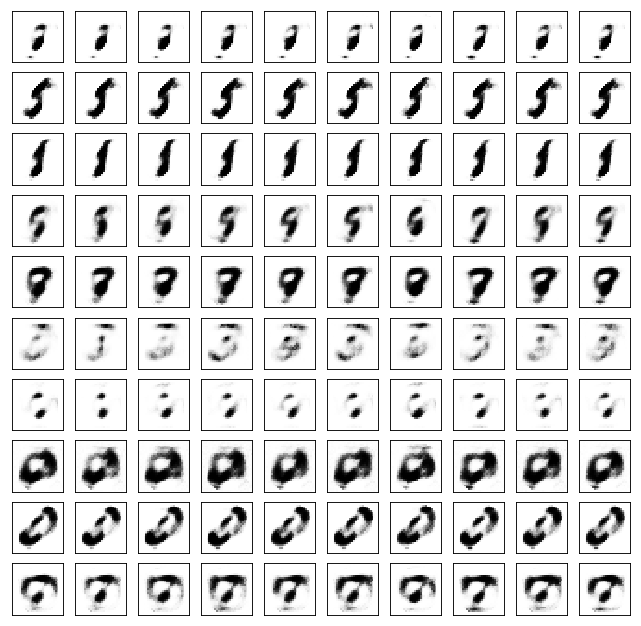

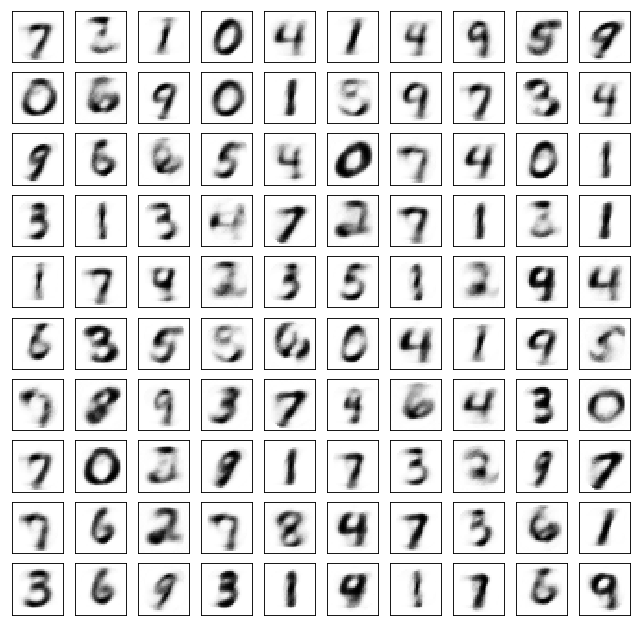

Test losses. E: 0.6498, AE: 0.1413, D: 0.6799
Train Epoch: 17 [0/50000 (0%)]	Losses E: 0.6497, AE: 0.1397, D: 0.6818
Train Epoch: 17 [25000/50000 (50%)]	Losses E: 0.4575, AE: 0.1875, D: 0.8271
Train Epoch: 17 [50000/50000 (100%)]	Losses E: 0.7204, AE: 0.1837, D: 0.8598


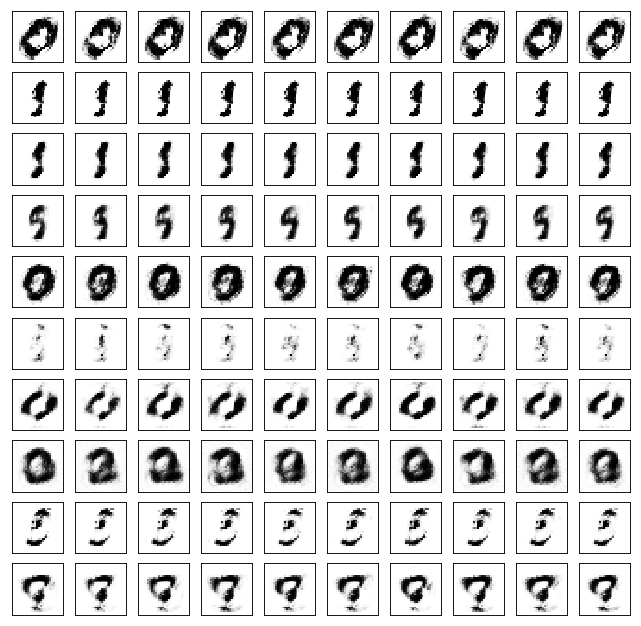

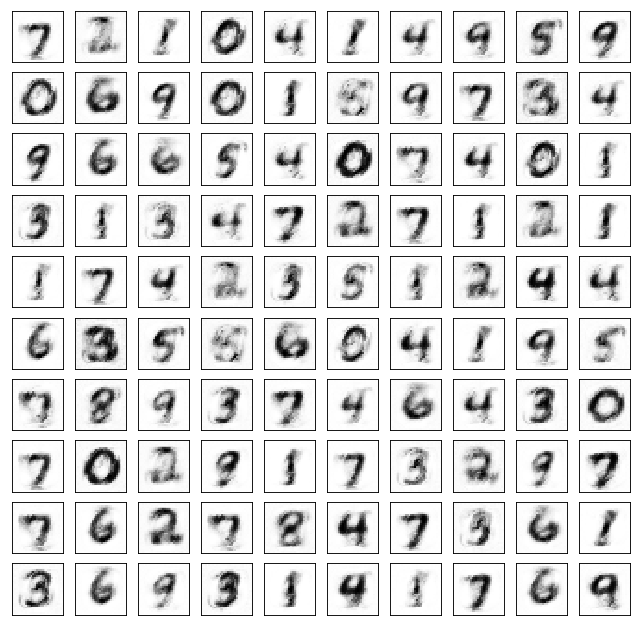

Test losses. E: 0.7200, AE: 0.1754, D: 0.8482
Train Epoch: 18 [0/50000 (0%)]	Losses E: 0.7172, AE: 0.1736, D: 0.8576
Train Epoch: 18 [25000/50000 (50%)]	Losses E: 0.6259, AE: 0.1440, D: 0.7212
Train Epoch: 18 [50000/50000 (100%)]	Losses E: 0.6306, AE: 0.1442, D: 0.6545


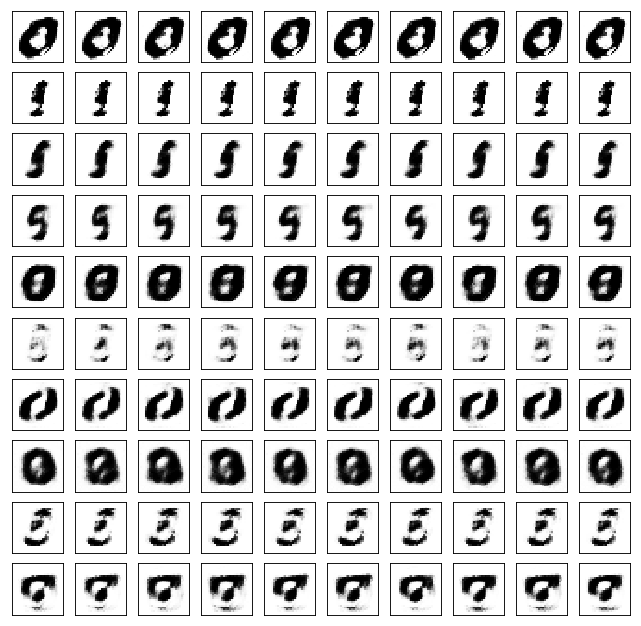

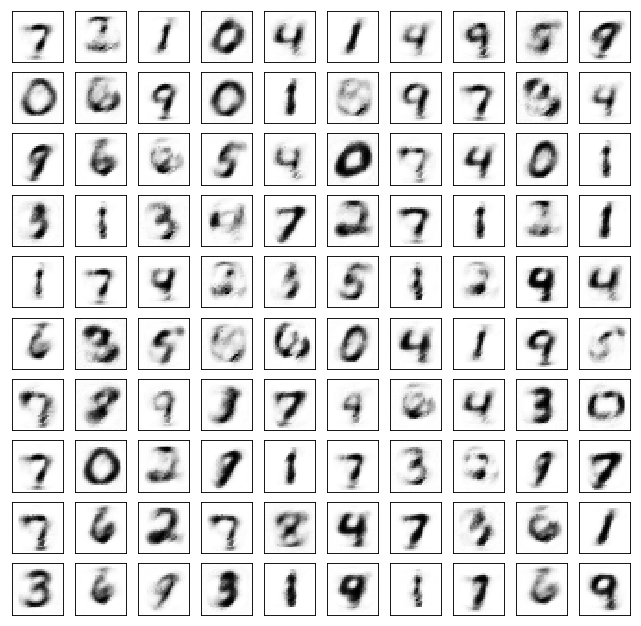

Test losses. E: 0.6247, AE: 0.1460, D: 0.6556
Train Epoch: 19 [0/50000 (0%)]	Losses E: 0.6273, AE: 0.1435, D: 0.6592
Train Epoch: 19 [25000/50000 (50%)]	Losses E: 1.0836, AE: 0.1610, D: 0.6837
Train Epoch: 19 [50000/50000 (100%)]	Losses E: 0.6669, AE: 0.1357, D: 0.7211


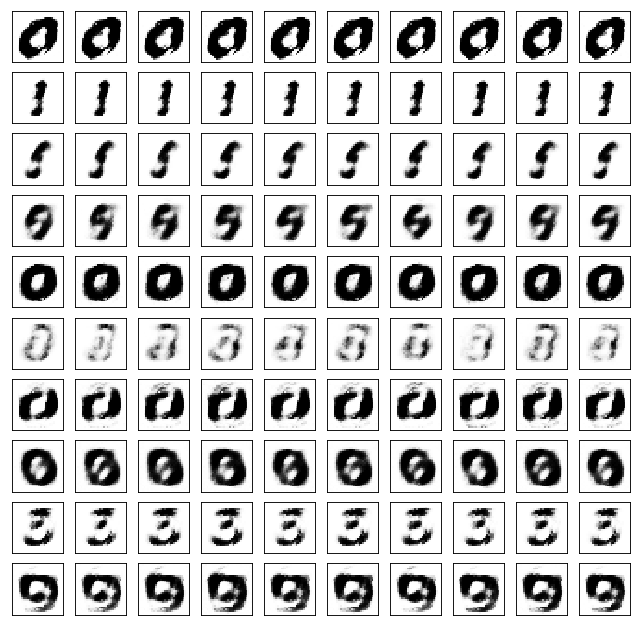

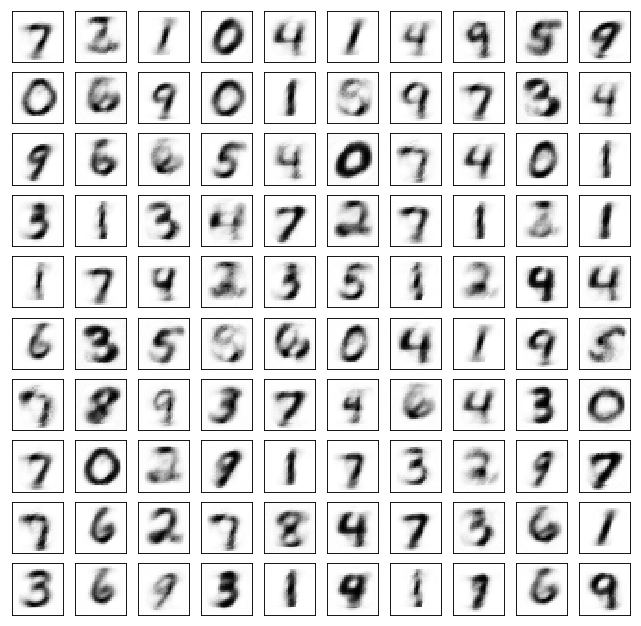

Test losses. E: 0.6658, AE: 0.1379, D: 0.7172
Train Epoch: 20 [0/50000 (0%)]	Losses E: 0.6648, AE: 0.1409, D: 0.7186
Train Epoch: 20 [25000/50000 (50%)]	Losses E: 0.6448, AE: 0.1302, D: 0.6522
Train Epoch: 20 [50000/50000 (100%)]	Losses E: 0.5281, AE: 0.1718, D: 0.8135


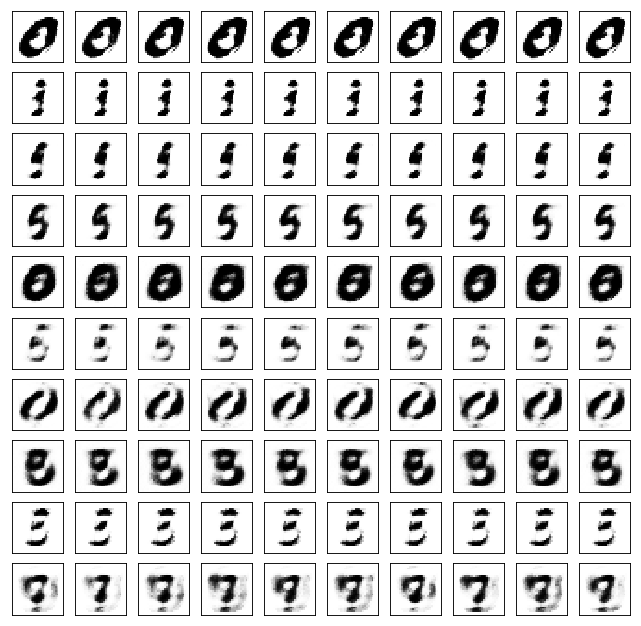

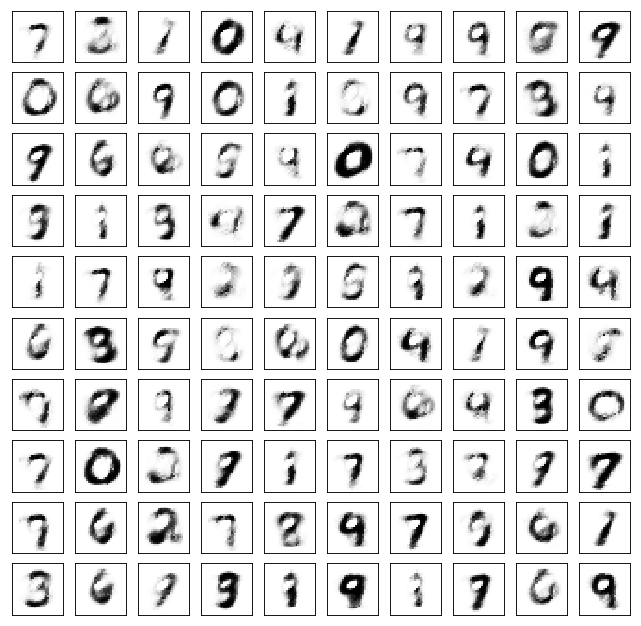

Test losses. E: 0.5098, AE: 0.1740, D: 0.8048
Train Epoch: 21 [0/50000 (0%)]	Losses E: 0.5407, AE: 0.1744, D: 0.8136
Train Epoch: 21 [25000/50000 (50%)]	Losses E: 0.6721, AE: 0.1394, D: 0.7386
Train Epoch: 21 [50000/50000 (100%)]	Losses E: 0.6255, AE: 0.1351, D: 0.6825


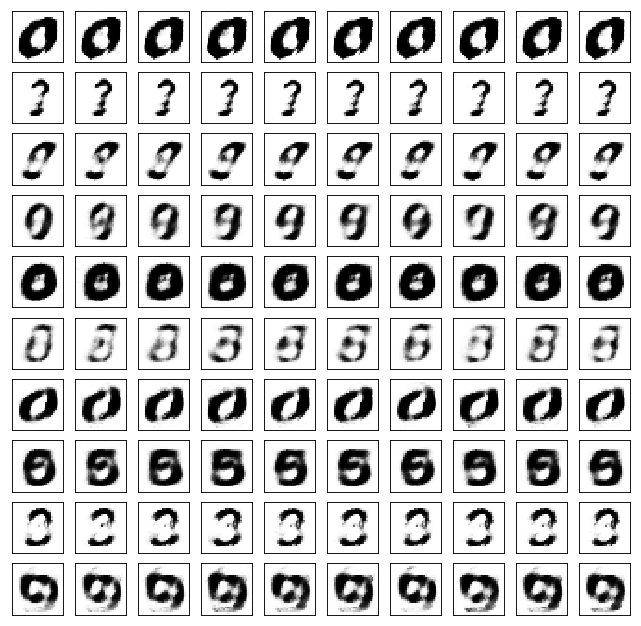

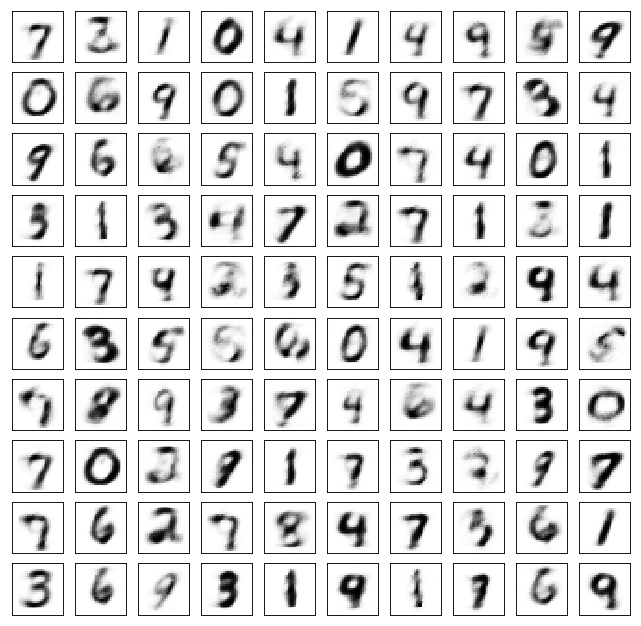

Test losses. E: 0.6247, AE: 0.1311, D: 0.6797
Train Epoch: 22 [0/50000 (0%)]	Losses E: 0.6271, AE: 0.1290, D: 0.6798
Train Epoch: 22 [25000/50000 (50%)]	Losses E: 0.7257, AE: 0.1847, D: 0.7120
Train Epoch: 22 [50000/50000 (100%)]	Losses E: 0.7005, AE: 0.1305, D: 0.7234


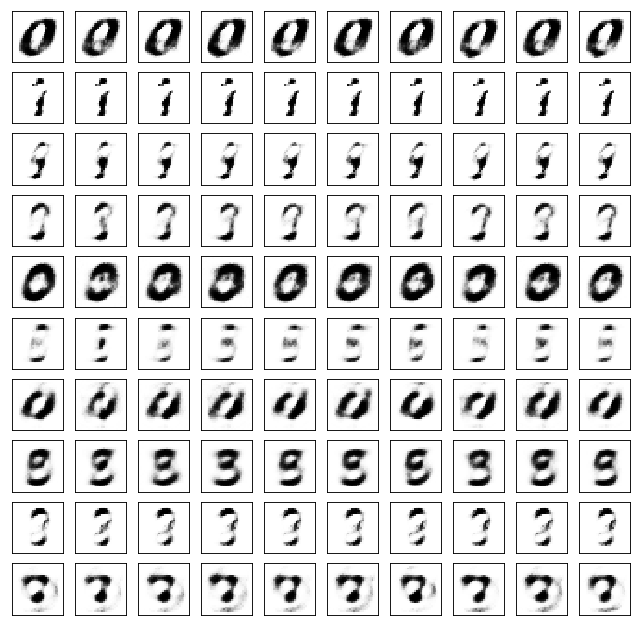

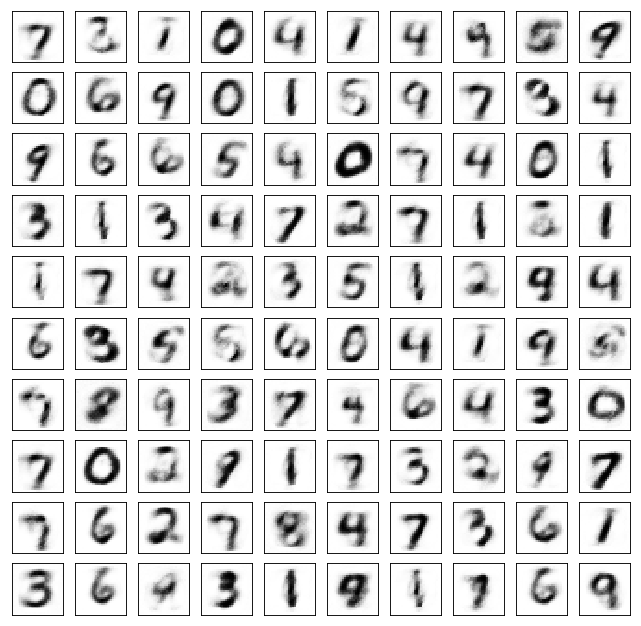

Test losses. E: 0.7017, AE: 0.1359, D: 0.7214
Train Epoch: 23 [0/50000 (0%)]	Losses E: 0.7010, AE: 0.1338, D: 0.7221
Train Epoch: 23 [25000/50000 (50%)]	Losses E: 0.6422, AE: 0.1269, D: 0.6764
Train Epoch: 23 [50000/50000 (100%)]	Losses E: 0.7299, AE: 0.1571, D: 0.7470


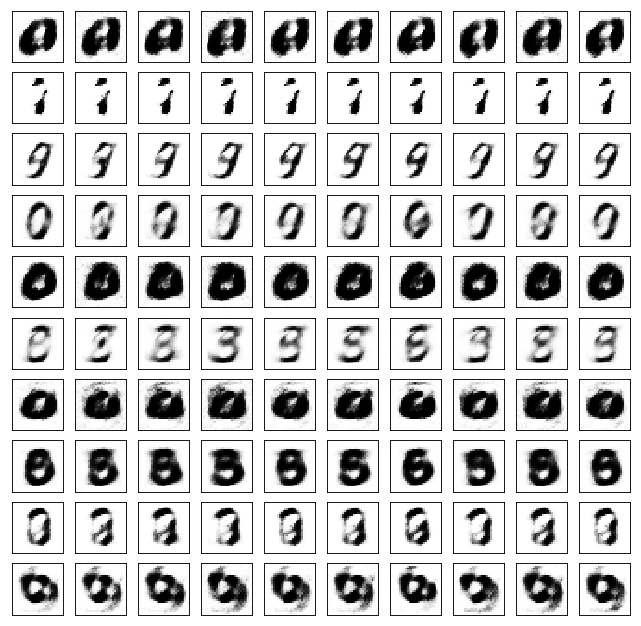

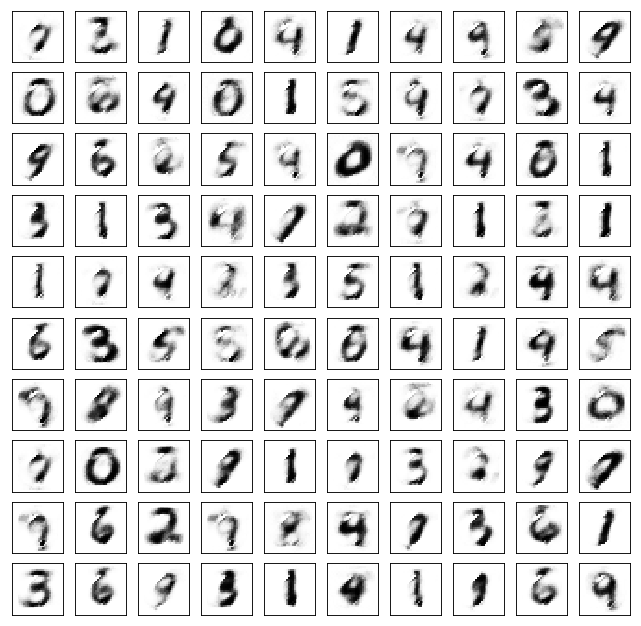

Test losses. E: 0.7271, AE: 0.1622, D: 0.7313
Train Epoch: 24 [0/50000 (0%)]	Losses E: 0.7343, AE: 0.1589, D: 0.7297
Train Epoch: 24 [25000/50000 (50%)]	Losses E: 0.6681, AE: 0.1384, D: 0.7117
Train Epoch: 24 [50000/50000 (100%)]	Losses E: 0.6415, AE: 0.1297, D: 0.7146


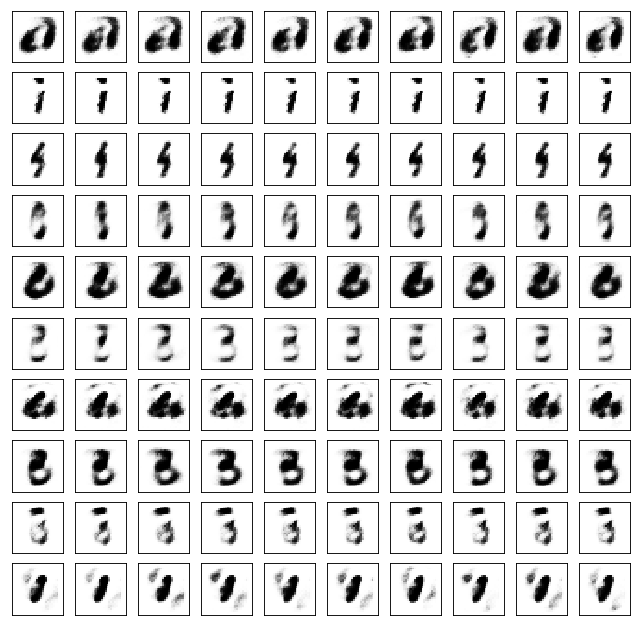

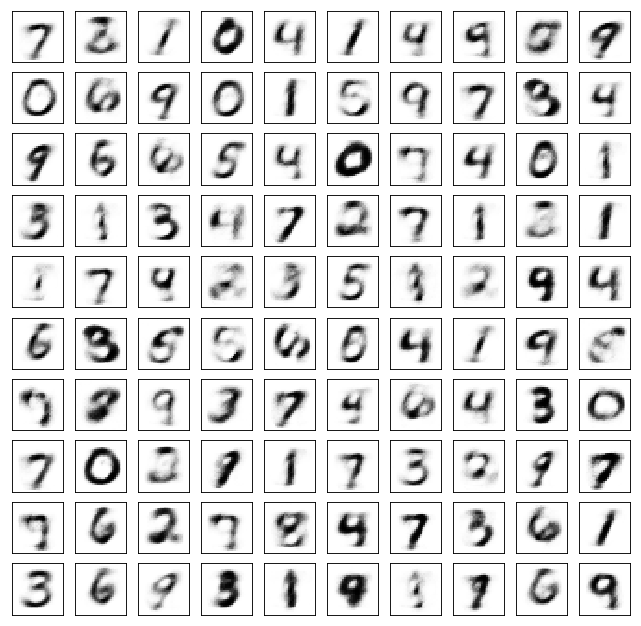

Test losses. E: 0.6355, AE: 0.1310, D: 0.7131
Train Epoch: 25 [0/50000 (0%)]	Losses E: 0.6445, AE: 0.1303, D: 0.7137
Train Epoch: 25 [25000/50000 (50%)]	Losses E: 0.6380, AE: 0.1986, D: 0.7752
Train Epoch: 25 [50000/50000 (100%)]	Losses E: 0.7572, AE: 0.1349, D: 0.6844


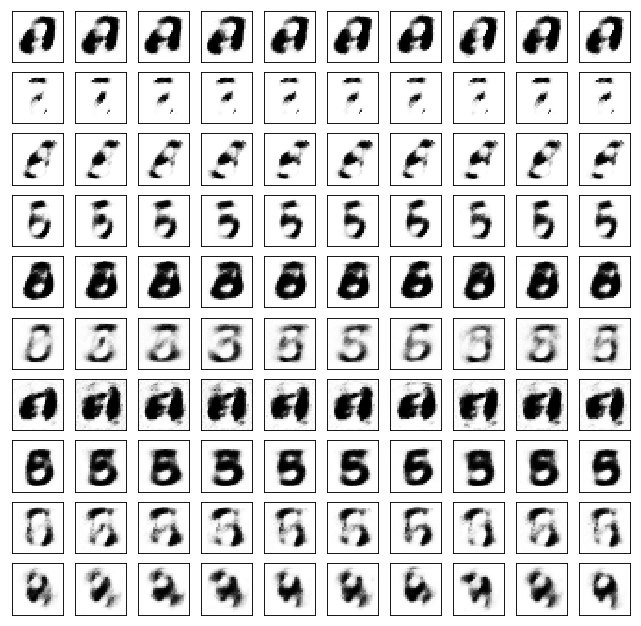

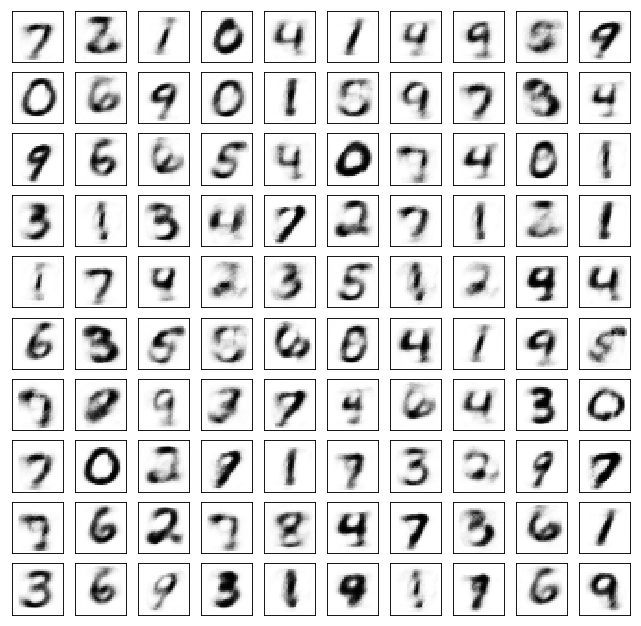

Test losses. E: 0.7516, AE: 0.1319, D: 0.6836
Train Epoch: 26 [0/50000 (0%)]	Losses E: 0.7545, AE: 0.1298, D: 0.6833
Train Epoch: 26 [25000/50000 (50%)]	Losses E: 0.7074, AE: 0.1407, D: 0.7022
Train Epoch: 26 [50000/50000 (100%)]	Losses E: 0.6810, AE: 0.1288, D: 0.6927


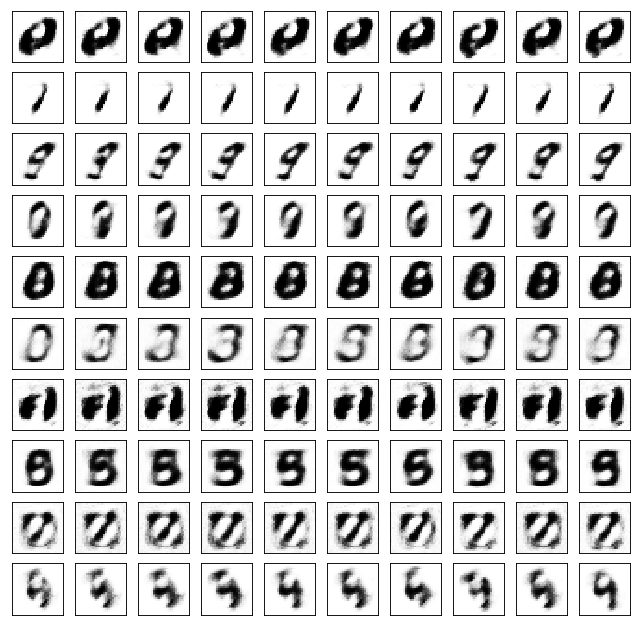

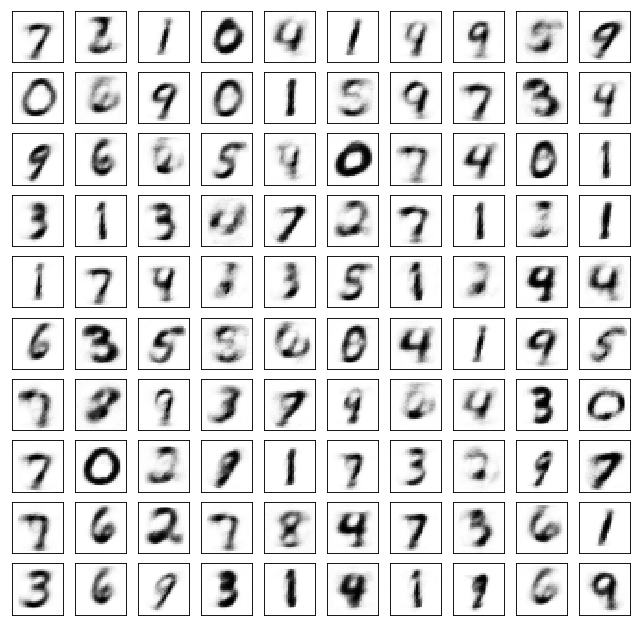

Test losses. E: 0.6773, AE: 0.1287, D: 0.6937
Train Epoch: 27 [0/50000 (0%)]	Losses E: 0.6767, AE: 0.1241, D: 0.6962


In [ ]:
for epoch in range(1, train_epoch + 1):
    Enc.train()
    Dec.train()
    Disc.train()
    train(epoch, Enc, Dec, Disc, train_log)
    Enc.eval()
    Dec.eval()
    Disc.eval()
    test(Enc, Dec, Disc, valid_loader, epoch, test_log)

In [ ]:
torch.save(Enc, './enc_aae_c_1')
torch.save(Dec, './dec_aae_c_1')
torch.save(Disc, './disc_aae_c_1')